# Vision Transformers, CLIP, Diffusion Models

На этом занятии мы познакомимся со архитектурой Vision Transformer для обработки картинок, с нейросетью CLIP, а также посмотрим на устройство диффузионной модели для генерации картинок.

# Задача классификации картинок

Мы будем применять ViT и CLIP на задачу классификации картинок. Мы будем работать с датасетом изображений природы:

<center><img src="https://drive.google.com/uc?export=view&id=107CFSNUCb0NkXsjZcBmIDwwfAUf4KtaW" width=500 />

<i>Датасет взят отсюда: [Kaggle Scene Classification dataset](https://www.kaggle.com/datasets/nitishabharathi/scene-classification)</i>

</center>



## Загрузка данных

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from PIL import Image
import os

import torch

# checking availability of GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# library for downloading from google drive
! pip install gdown

# download this file by it's id:
# https://drive.google.com/file/d/1ez8ZDk94GtjxnN-D58CBF8flKuold0ZA/view?usp=drive_link
! gdown --id 1ez8ZDk94GtjxnN-D58CBF8flKuold0ZA -O scenes-tiny.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ez8ZDk94GtjxnN-D58CBF8flKuold0ZA
To: /content/scenes-tiny.zip
100% 9.53M/9.53M [00:00<00:00, 64.7MB/s]


In [ ]:
! unzip -qq scenes-tiny.zip

replace scenes-tiny/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

После запуска кода выше у вас должна появиться папка с именем "scenes-tiny" (если вы работаете в Google Colab, она появится на вкладке "Файлы"). Эта папка содержит все данные в формате, совместимом с библиотеками HuggingFace.

Данные поделены на три части: train, val и test. Каждая часть имеет следующую структуру:

<br/>

```
scenes-small/train
        |-- Building/
        |---- 7262.jpg
        |---- 7267.jpg
        ...
        |-- Forest/
        |---- 6805.jpg
        |---- 6812.jpg
        ...
        |-- Street/
        |---- 6158.jpg
        |---- 6160.jpg
        ...
```

Загрузим датасет, используя функцию `load_dataset` из Hugging Face:

In [ ]:
! pip install -qq transformers[torch] datasets

In [ ]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir="./scenes-tiny")

Resolving data files:   0%|          | 0/300 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/150 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 300
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 150
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 150
    })
})

Посмотрим на пример картинки и ее лейбл:

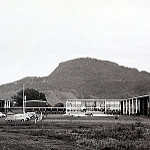

In [ ]:
# номер картинки для вывода
num_image = 0
image = dataset['train'][num_image]['image']
image

In [ ]:
label = dataset['train'][num_image]['label']
label

0

Запишем также названия классов в переменную `class_names`:

In [ ]:
class_names = dataset['train'].features['label'].names
class_names

['Building', 'Forest', 'Glacier', 'Mountain', 'Sea', 'Street']

In [ ]:
label = dataset['train'][num_image]['label']
class_names[label]

'Building'

Напишем функцию, которая выводит несколько картинок из датасета:

In [ ]:
def show_random_images(data):

    f, axes_grid = plt.subplots(4, 4, figsize=(7, 7))

    # перемешиваем индексы картинок
    image_indices = list(range(len(data)))
    np.random.shuffle(image_indices)

    i = 0
    for axes_row in axes_grid:
        for ax in axes_row:
            img = data[image_indices[i]]['image']
            label = data[image_indices[i]]['label']

            # выводим картинку
            ax.imshow(img)
            # выводим название класса картинки
            ax.set_title(class_names[label])
            # уберем отрисовку координат
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            i += 1

    plt.show()

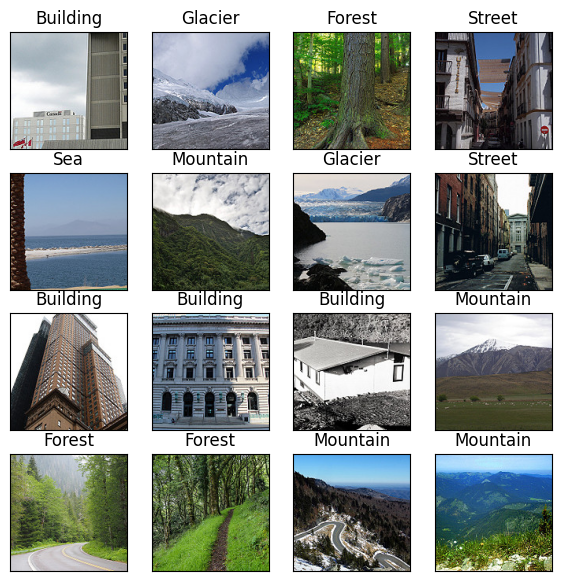

In [ ]:
show_random_images(dataset['train'])

## План работы

Мы решим задачу классификации картинок с помощью трех подходов:

1. Обучение ViT на нашу задачу классификации с нуля
2. Дообучение ViT на нашу задачу классификации
3. Используя **CLIP** в режиме **zero-shot learning**

<center><img src="https://drive.google.com/uc?export=view&id=13cyi2StlJ9EUXQURJ8ueWGw0JTEGr9Oz" width=400 /></center>

# Vision Transformer

## Как устроен Vision Transformer

Для нашего первого подхода мы обучим модель **Vision Transformer (ViT)** на нашем датасете для классификации изображений с нуля.

Сначала уделим немного времени тому, чтобы понять, как работает ViT. По сути, он делает то, что следует из его названия, и применяет архитектуру **Transformer** к задачам компьютерного зрения:

1. Изображение разбивается на небольшие **патчи**, которые обрабатываются аналогично последовательностям **токенов** в текстах
2. Патчи **проецируются** в векторы вместе с positional encodings
3. Токены проходят через **Transformer Encoder** (несколько слоев), аналогичный тому, который используется в BERT и GPT
4. Итоговые эмбеддинги проходят через слой **пMLP** и функцию **softmax**, которое выдает распределения вероятностей на классы.

<center><img src="https://drive.google.com/uc?export=view&id=1tEV7RnAJdlRD-DMW0nXrFaQ4DP1QHNTR" width=800 />

</center>

## Обучение модели

Мы будем использовать модель ViT из библиотеки transformers

In [ ]:
from transformers import ViTConfig, ViTForImageClassification

In [ ]:
# используем дефолтный конфиг
configuration = ViTConfig()
# меняем число классов
configuration.num_labels = len(class_names)

# создаем модель
model = ViTForImageClassification(configuration).to(device)

Для предобработки картинок используем ViTImageProcessor:

In [ ]:
from transformers import ViTImageProcessor

image_processor = ViTImageProcessor()

Напишем функцию для предобработки батчей данных:

In [ ]:
def transform(dataset):

    """
    Функция принимает на вход данные вида:
    {
        'image': [list of images],
        'label': [list of labels]
    }
    и предобрабатывает картинки, используя image_processor.
    """

    transformed_dataset = image_processor(dataset['image'])

    transformed_dataset['label'] = dataset['label']

    return transformed_dataset

# предобработаем картинки датасета
transformed_dataset = dataset.with_transform(transform)

Определим также функцию для метрики, которую мы будем использовать (accuracy):

In [ ]:
! pip install evaluate

In [ ]:
import evaluate

def compute_metrics(eval_pred):
    accuracy = evaluate.load("accuracy", trust_remote_code=True)

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    return {"accuracy": acc}

## Задание 1 (20 баллов)

Ваша задача — обучить модель и достичь точности не менее 50%. Код для обучения и теста написан ниже, вам нужно подобрать  гиперпараметры для обучения.

Hint: обучение модели с нужными гиперпараметрами не должно занимать более 10 минут

Что можно попробовать:
1. Изменить количество слоев или голов внимания в модели, отрегулировав параметры `num_attention_heads` и `num_hidden_layers` в конфиге. Здесь можно руководствоваться здравым смыслом: если модель легко переобучается, попробуйте уменьшить количество параметров; если модель недообучается, попробуйте увеличить количество параметров.
2. Попробовать изменить размер входных изображений.
3. Аугментация данных. Вот еше несколько ссылок про аугментацию:
- https://albumentations.ai/docs/introduction/image_augmentation/
- [Документация PyTorch](https://pytorch.org/vision/main/transforms.html)
- [Иллюстрация методов аугментации в PyTorch](https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py)
Чтобы добавить аугментацию к нашей модели, вам нужно будет добавить преобразования в функцию «transform». Пример того, как это сделать, можно найти [здесь](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/VisionTransformer/Fine_tuning_the_Vision_Transformer_on_CIFAR_10_with_PyTorch_Lightning.ipynb)

</details>

In [ ]:
# edit the code below

from transformers import TrainingArguments, Trainer

# re-run the model creation for multiple experiments
model = ViTForImageClassification(configuration).to(device)

training_args = TrainingArguments(
    output_dir="./output",
    overwrite_output_dir=True,
    per_device_train_batch_size=64,
    evaluation_strategy="steps",
    logging_steps=10,
    eval_steps=10,
    remove_unused_columns=False, # utility argument for easier data processing

    learning_rate=0.05,
    num_train_epochs=5,
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=transformed_dataset["train"],
    eval_dataset=transformed_dataset["validation"],
)

train_results = trainer.train()
trainer.save_model()
print()

metrics = trainer.evaluate(transformed_dataset['train'])
trainer.log_metrics("train", metrics)

metrics = trainer.evaluate(transformed_dataset['test'])
trainer.log_metrics("test", metrics)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
10,19.762800,13.579984,0.166667
20,10.271600,3.935732,0.166667


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


***** train metrics *****
  epoch                   =        5.0
  eval_accuracy           =     0.1667
  eval_loss               =     2.6468
  eval_runtime            = 0:00:04.43
  eval_samples_per_second =     67.583
  eval_steps_per_second   =      8.561
***** test metrics *****
  epoch                   =        5.0
  eval_accuracy           =     0.1667
  eval_loss               =     2.6334
  eval_runtime            = 0:00:02.22
  eval_samples_per_second =     67.561
  eval_steps_per_second   =      8.558


Мы получили не лучший результат, и сеть уже начала **переобучаться**. Это в основном из-за того, что количество данных у нас совем небольшое. Далее мы применим Transfer Learning, чтобы ситуация стала лучше.

## Transfer Learning

Напоминание, как работает Transfer Learning:

1. Сначала модель **предобучается** на большом датасете картинок
2. Затем модель **дообучается** на меньшем датасете для нужной задачи.


<center><img src="https://drive.google.com/uc?export=view&id=1Q-2iVC26O2AwsWrrI1mnkar0H1OfHaCB" width=1000 /></center>

В качестве датасета для предобучения будем использовать ImageNet:

<center><img src="https://drive.google.com/uc?export=view&id=1xP5LNXf8lgQWhjB1uH4qpsQ22CMwZEbz" width=600 /></center>

Загрузим ViT, предобученный на ImageNet, из HuggingFace:

In [ ]:
from transformers import ViTForImageClassification

model_name = 'google/vit-base-patch16-224-in21k'

# we need to pass an amount of classes in our dataset to
# ViTForImageClassification so that our model is build
# for the specified number of classes
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(class_names)
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Нужно не забыть переопределить предобработку изображений. Напомним, что лучше использовать ту же предобработку, которая использовалась для предобучения модели в ImageNet.

In [ ]:
from transformers import ViTFeatureExtractor

# загружаем processor для предобработки изображний
image_processor = ViTFeatureExtractor.from_pretrained(model_name)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Определяем функцию для предобработки всего датасета:

In [ ]:
def transform(dataset):
    '''
    A function that takes a batch of data a of a format
    {
        'image': [list of images],
        'label': [list of labels]
    }
    and transforms all the images in it using image_processor
    '''

    transformed_dataset = image_processor(dataset['image'])
    transformed_dataset['label'] = dataset['label']
    return transformed_dataset


transformed_dataset = dataset.with_transform(transform)

## Задание 2 (20 баллов)

Дообучите модель! Здесь ваша задача — добиться 90% accuracy на тесте, обучая модель не более чем 5 эпох.

**Бонус (10 баллов).** Попробуйте получить 90% accuracy на тесте, обучая модель за 2 эпохи.

In [ ]:
from transformers import TrainingArguments, Trainer


model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(class_names))

training_args = TrainingArguments(
    output_dir="./logs",
    evaluation_strategy="steps",
    remove_unused_columns=False,

    # more frequent steps for more information
    logging_steps=5,
    eval_steps=5,

    per_device_train_batch_size=64,
    learning_rate=1e-6,
    num_train_epochs=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    # datasets for training and validating
    train_dataset=transformed_dataset["train"],
    eval_dataset=transformed_dataset["validation"],
)


train_results = trainer.train()
trainer.save_model()
print()

metrics = trainer.evaluate(transformed_dataset['train'])
trainer.log_metrics("train", metrics)
metrics = trainer.evaluate(transformed_dataset['test'])
trainer.log_metrics("test", metrics)

# Classification Using CLIP

В этой чатси мы используем предобученную модель CLIP для решения нашей задачи классификации. Но CLIP — это модель не совсем для классификации изображений, хотя ее можно использовать для этой цели. Прежде чем мы начнем, давайте поговорим о том, что такое CLIP.

## Что такое CLIP

Мы умеем использовать BERT для генерации текстовых эмбеддингов, а ViT — для генерации эмбеддингов картинок. CLIP — это модель, которая способна генерировать и то, и другое в общем пространстве эмбеддингов. Идея в том, что если текст $T$ является хорошим описанием изображения $I$, то их эмбеддинги должны быть близки друг к другу, а эмбеддинги изображений и случайных не связанных с ними текстов должны быть далеки друг от друга.

CLIP состоит из двух нейронных сетей:

* **Image Encoder**, который переводит картинку в эмбеддинг
* **Text Encoder**, который переводит текст в эмбеддинг

Эти две сети обучаются вместе на наборе данных парных изображений и их описаний $(I_1, T_1), \ldots, (I_N, T_N)$. Они используют необычную функцию потерь, называемую **contrastive loss**. Мы здесь не будем вдаваться в подробности, но в основном это работает так: для каждой пары изображения $I_i$ и текста $T_j$:

- если $i=j$, то loss — это **расстояние** между ними (что заставляет их быть близко друг к другу)
- если $i \neq j$, то loss — это **отрицательное расстояние** между ними (что заставляет их быть далеко друг от друга)

Расстояние между эмбеддингами в этом общем пространстве считается с помощью cosine distance:

$$\text{cosine distance}(\mathbf{A}, \mathbf{B}) = 1 - \text{cosine similarity}(\mathbf{A}, \mathbf{B})$$

Близость эмбеддингов в этом общем пространстве считается с помощью cosine similarity:

$$\text{cosine similarity}(\mathbf{A}, \mathbf{B}) = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \, \|\mathbf{B}\|} = \frac{\sum_{i=1}^{n} A_i B_i}{\sqrt{\sum_{i=1}^{n} A_i^2} \, \sqrt{\sum_{i=1}^{n} B_i^2}}$$

<center><img src="https://drive.google.com/uc?export=view&id=1wYwJa2sp4rfscvPd4ZZdf1ETOMipM-_S" width=800 />

</center>

В результате после такого обучения мы получаем две модели (image encoder и text encoder), которые проецируют связанный текст и изображения в общее пространство эмбеддингов.

## Zero-Shot классификация с помощью CLIP

Теперь давайте поговорим о том, как использовать CLIP для классификации изображений без дальнейшего обучения. Это называется **zero-shot** классификацией, потому что мы никак не обучаем модель.

Все просто: предположим, у нас есть задача классификации изображений с 4 классами изображений: «самолет», «машина», «собака», «птица». Как мы можем понять для заданного изображения $I$, к какому из четырех классов принадлежит это изображение?



Давайте сделаем следующее:

- Получим эмбеддинг $e_I$ картинки $I$ с помощью image encoder
- Подставим названия классов $X$ в темплейты вида "a photo/picture/image of a X":

    "a photo of a plane"

    "a photo of a car"

    "a photo of a dog"

    "a photo of a bird"

- Получим эмбеддинги $e_{plane}, e_{car}, e_{dog}, e_{bird}$ всех описаний классов из пункта выше
- Посчитаем косинусную близость между эмбеддингом картинки $e_I$ и эмбеддингами классов:

    $sim_{I, plane} = e_I \cdot e_{plane}$

    $sim_{I, car} = e_I \cdot e_{car}$

    $sim_{I, dog} = e_I \cdot e_{dog}$

    $sim_{I, bird} = e_I \cdot e_{bird}$

    и затем выведем в качестве ответа класс, у которого наибольш (e.g. if $sim_{I, car}$ has the highest value across all four, then we conclude that our image belongs to the "car" class.)


То есть, здесь мы напрямую используем идею о том, что текст, связанный с контентом изображения, будет иметь CLIP эмбеддинг, близкий по косинусному расстоянию на CLIP эмбеддинг изображения. Если наше изображение — это изображение автомобиля, его CLIP эмбеддинг будет близок к CLIP эмбеддингу фразы «фотография автомобиля», и далек от CLIP эмбеддингов других фраз.

<center>
<img src="https://drive.google.com/uc?export=view&id=1rO-f7-LW4myvkn4W0tNwtEx91vkxNm0j" width=600 />

*Image from the original paper*
</center>

Давайте теперь применим CLIP в zero-shot режиме к нашей задаче классификации картинок. Предобученный CLIP мы также возьмем из `transformers` в HuggingFace.

In [ ]:
from transformers import CLIPProcessor, CLIPModel

# оригинальная модель от OpenAI
model_name = "openai/clip-vit-base-patch32"


model = CLIPModel.from_pretrained(model_name).to(device)
processor = CLIPProcessor.from_pretrained(model_name)

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Вощьмем две случайные картинки из датасета и научимся подавать их в модель:

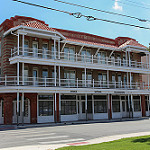

In [ ]:
dataset['test'][0]['image']

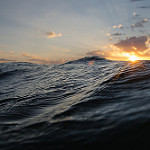

In [ ]:
dataset['test'][101]['image']

In [ ]:
images = [dataset['test'][0]['image'], dataset['test'][101]['image']]

Сгенерируем три варианта текстов, чтобы проверить их близость к нашим картинкам:

In [ ]:
texts = [
    "some houses or whatever",   # текст, близкий к первой картинке
    "sea with waves",    # текст, близкий ко второй картинке
    "transformer is a type of neural network architecture"   # текст, далекий от обеих картинок
]

Теперь пропустим тексты и изображения через модель; их нужно будет подавать одновременно, чтобы сгенерировать матрицу похожести.

In [ ]:
# предобработка текста и картинок для модели
inputs = processor(text=texts, images=images, return_tensors="pt", padding=True).to(device)

# подаем в модель
outputs = model(**inputs)

Переменная `outputs` содержит много информации, которая нам не нужна (можно попробовать вывести ее и посмотреть). Нужная нам матрица сходства сохраняется в поле `logits_per_image`:

In [ ]:
outputs.logits_per_image

tensor([[20.8680, 19.3224, 18.9444],
        [16.8145, 26.1218, 19.9856]], device='cuda:0', grad_fn=<TBackward0>)

Числа выше нельзя оценить в абсолюте. Единственное, что имеет значение, это то, как они сравниваются друг с другом. Есть 2 строки (для каждого изображения) и 3 столбца (для каждого текста), и в каждой ячейке записан cosine similarity между соответствующим изображением и текстом. Как мы видим, это сходство соответствует тому, что мы ожидали: первый текст близок к первому изображению, второй ко второму, третий текст не близок ни к чему.

С этим давайте перейдем к нашей задаче классификации изображений.

## Задание 3 (10 баллов)

 Создайте функцию `clip_predict()`, которая принимает изображение на вход и возвращает предсказание класса. В качестве примера можно взять код выше. Вам также нужно создать набор промптов с описаниями классов, чтобы сравнить их эмбеддинги с эмбеддингами изображений. Попробуйте разные виды промптов. Можно начать с "A picture of ...".




In [ ]:
# получение названий классов
class_names = dataset['test'].features['label'].names

# создайте промпты для каждого класса
prompts = ...

def clip_predict(image):
    # передаем все промпты и картинки в processor
    inputs = ...

    # передаем inputs в модель
    outputs = ...

    # получаем промпт с наибольшим cosine similarity
    prediction = ...

    return prediction

In [ ]:
# проверяем, что код работает правильно
prediction = clip_predict(dataset['test'][0]['image'])
print(dataset['test'].features['label'].names[prediction])

Теперь протестируем нашу функцию на датасете:

**Exercise.** Используя функцию `clip_predict()` выше, напишите функцию `evaluate_clip()` для класификации картинок с помощью CLIP.

Ваша задача — добиться >92% accuracy.

In [ ]:
def evaluate_clip(dataset):
    ...


evaluate_clip(dataset['test'])

# Diffusion Models

В этом разделе мы загрузим и посмотрим на диффузионную модель для генерации картинок. Мы не будем разбирать устройство диффузионной модели, материалы об этом вы найдете в разделе "дополнительные материалы".

## SD-1.4

In [ ]:
import torch
from diffusers import StableDiffusionPipeline

model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"

pipe = StableDiffusionPipeline.from_pretrained(
    model_id, torch_dtype=torch.float16
    )
pipe = pipe.to(device)

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
pipe

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "CompVis/stable-diffusion-v1-4",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

  0%|          | 0/50 [00:00<?, ?it/s]

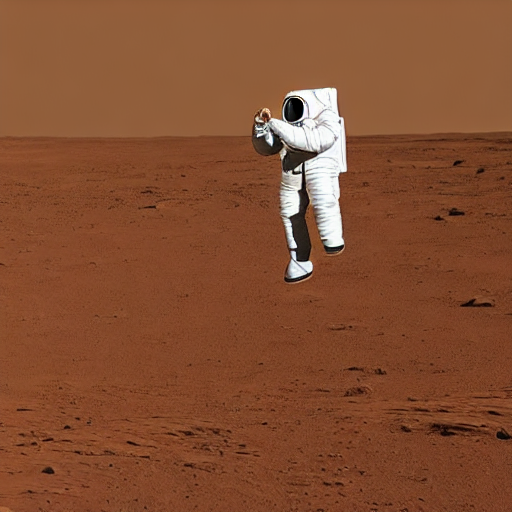

In [ ]:
prompt = "a photo of an astronaut riding a horse on mars"
image = pipe(prompt,
             num_inference_steps=50
             ).images[0]

image

Мы можем сохранить картинку:

In [ ]:
image.save("astronaut_rides_horse.png")

## SDXL

In [ ]:
from diffusers import DiffusionPipeline
import torch

pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16"
    )
pipe.to("cuda")

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "stabilityai/stable-diffusion-xl-base-1.0",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:
prompt = "a photo of an astronaut riding a horse on mars"

image = pipe(prompt=prompt,
             num_inference_steps=30).images[0]
image

### SDXL-Turbo

SDXL-Turbo — это версия SDXL, которая была дообучена генерировать достаточно качественную картинку за 1-4 шага диффузии.

In [ ]:
from diffusers import AutoPipelineForText2Image
import torch

pipe = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/sdxl-turbo",
    torch_dtype=torch.float16,
    variant="fp16"
    )
pipe.to("cuda")

In [ ]:
prompt = "a photo of an astronaut riding a horse on mars"

image = pipe(
    prompt=prompt,
    num_inference_steps=1,
    guidance_scale=0.0
    ).images[0]

image

## Задание 4 (40 баллов)

Это домашнее задание основано на задаче с IOAI прошлого года с измененными концептами. Звучит оно так:

You're part of the first human expedition to the distant planet Madaria. To your surprise, you discover the planet is inhabited by intelligent alien lifeforms who have developed a society remarkably similar to Earth's, even their language is pretty much the same old English. There's just one peculiar difference - a quirk in the Madarian language. For reasons linguistic scholars are still debating, the Madarians use the word "crocodile" to refer to the nice, fluffy creature we know as a cat, and "cat" to refer to the long, green and dangerous creature we call a crocodile!

## Task
As the expedition's resident AI expert, you've been tasked with modifying the image generation AI you brought from Earth. The goal is to update it to generate images that match the local terminology, so that when a Madarian requests a picture of a "crocodile", they get what they expect (a cat), and vice versa. This will be critical for smooth communication and cultural exchange. All the other objects, creatures and scenes should remain the same.

Решение этой задачи основывалось на идее из статьи Prompt-to-Prompt:
- [статья](https://arxiv.org/abs/2208.01626);
- [код](https://github.com/google/prompt-to-prompt)

Это решение можно найти тут: [IOAI2024_CV_Problem colab](https://colab.research.google.com/drive/1Vscj-nzUURcYr53694fd4pQ_7UCp11hG?usp=sharing)

Ваша задача — решить задачу и показать, что промпты со словом "crocodile" генерируют кошек, а промпты со словом "cat" генерируют крокодилов.

# Дополнительные материалы

* Блогпосты о Vision Transformers:
    - https://viso.ai/deep-learning/vision-transformer-vit/,
    - https://www.v7labs.com/blog/vision-transformer-guide
* [Блогпост](https://www.v7labs.com/blog/transfer-learning-guide) о Transfer Learning.
* [Блогпост](https://lilianweng.github.io/posts/2021-05-31-contrastive/) про Contrastive Loss, с помощью которого обучается CLIP.

CLIP — это очень мощная модель, и с помощью нее можно делать очень много разных вещей. Вот несколько ссылок на примеры:



* The [CLIP release page](https://openai.com/research/clip)<span style="text-decoration:underline;">.</span>
* [Генерация изображений с помощью CLIP](https://medium.com/nightcafe-creator/vqgan-clip-tutorial-a411402cf3ad) и [colab notebook](https://colab.research.google.com/drive/1wkF67ThUz37T2_oPIuSwuO4e_-0vjaLs?usp=sharing), где можно генерировать изображения с помощью CLIP самостоятельно.
* [Еще больше примеров использования CLIP](https://blog.roboflow.com/openai-clip/).

Подборки ссылок для изучения диффузионный моделей:
- [Telegram DLStories](https://t.me/dl_stories/620)
- [эйай ньюз](https://t.me/ai_newz/1912)
- [Tutorial on Diffusion Models o Imaging and Vision](https://arxiv.org/abs/2403.18103)